### Build Equiangular weight matrix

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
import hashlib
import zipfile

import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import healpy as hp

plt.rcParams['figure.figsize'] = [10, 10]

In [3]:
import numpy as np
from scipy import sparse

from pygsp import utils
from pygsp.graphs import Graph
from pygsp.graphs import NNGraph

In [4]:
class SphereIcosahedron(Graph):
    def __init__(self, order, sampling='vertex', **kwargs):
        from collections import deque
        ## sampling in ['vertex', 'face']
        PHI = (1 + math.sqrt(5))/2
#         x, y, z = 
#         pointUpFor = deque([0, 1, PHI])
#         pointUpBack = deque([0, -1, PHI])
#         pointDownFor = deque([0, 1, -PHI])
#         pointDownBack = deque([0, -1, -PHI])
#         for i in range(3):
            
#         theta = [0] + 5*[np.pi/2-np.arctan(0.5)] + 5*[np.pi/2+np.arctan(0.5)] + [np.pi]
#         phi = [0] + np.linspace(0, 2*np.pi, 5, endpoint=False).tolist() +  (np.linspace(0, 2*np.pi, 5, endpoint=False)+(np.pi/5)).tolist() + [0]
        
        coords = 0
        W = 0
        super(SphereIcosahedron, self).__init__(W=W, coords=coords,
                                     plotting=plotting, **kwargs)

In [356]:
class SphereHealpixNN(NNGraph):
    def __init__(self, nside, n_neighbors, nest=True, **kwargs):
        import healpy as hp
        self.nside = nside
        npix = 12 * nside**2
        indexes = np.arange(npix)
        x, y, z = hp.pix2vec(nside, indexes, nest=nest)
        coords = np.vstack([x, y, z]).transpose()
        coords = np.asarray(coords, dtype=np.float32)
        
        plotting = {
            'vertex_size': 80,
            "limits": np.array([-1, 1, -1, 1, -1, 1])
        }
        
        super(SphereHealpixNN, self).__init__(coords, k=n_neighbors, center=False, rescale=False,
                                     plotting=plotting, **kwargs)
        

In [354]:
class SphereHealpix(Graph):
    def __init__(self, nside, nest=True, **kwargs):
        import healpy as hp
        self.nside = nside
        npix = 12 * nside**2
        indexes = np.arange(npix)
        x, y, z = hp.pix2vec(nside, indexes, nest=nest)
        coords = np.vstack([x, y, z]).transpose()
        coords = np.asarray(coords, dtype=np.float32)
        
        neighbors = hp.pixelfunc.get_all_neighbours(nside, indexes, nest=nest)
        col_index = neighbors.T.reshape((npix * 8))
        row_index = np.repeat(indexes, 8)
        keep = (col_index < npix)
        # Remove fake neighbors (some pixels have less than 8).
        keep &= (col_index >= 0)
        col_index = col_index[keep]
        row_index = row_index[keep]
        distances = np.sum((coords[row_index] - coords[col_index])**2, axis=1)
        plt.hist(distances, 100)
        kernel_width = np.mean(distances)
        weights = np.exp(-distances / (2 * kernel_width))
        W = sparse.csr_matrix(
            (weights, (row_index, col_index)), shape=(npix, npix), dtype=np.float32)
        
        plotting = {"limits": np.array([-1, 1, -1, 1, -1, 1])}
        super(SphereHealpix, self).__init__(W=W, coords=coords,
                                     plotting=plotting, **kwargs)
        

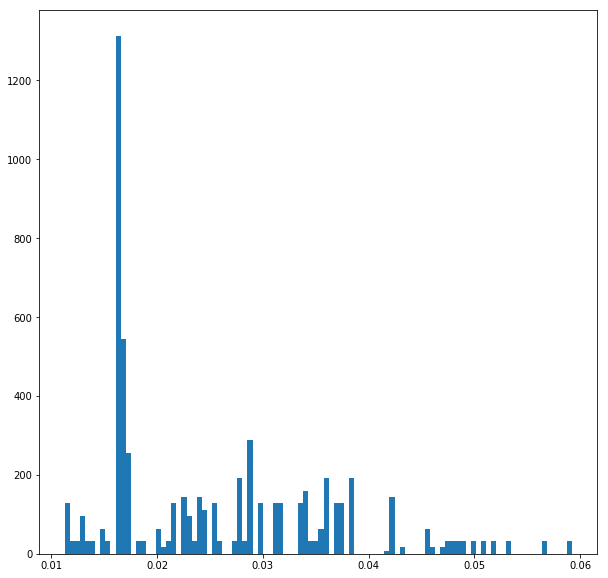

In [366]:
graphHp = SphereHealpix(8, True)
graphHpNN = SphereHealpixNN(8, 6, True)

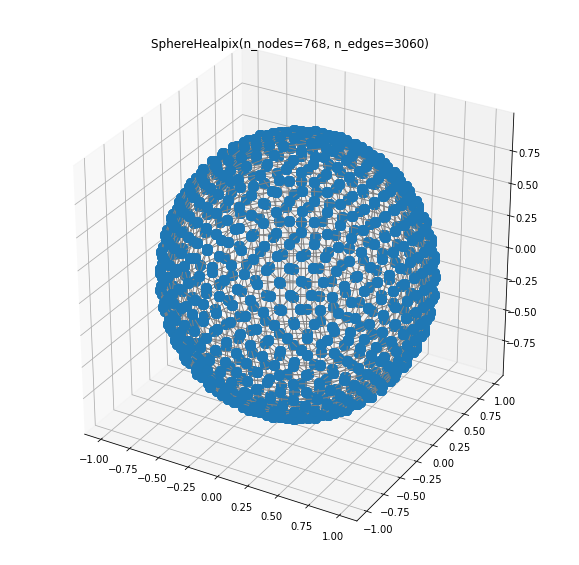

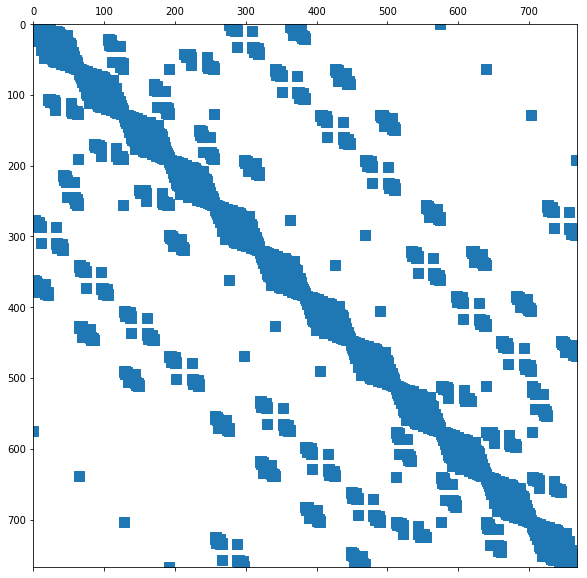

In [367]:
graphHp.plot()
plt.figure()
plt.spy(graphHp.W)

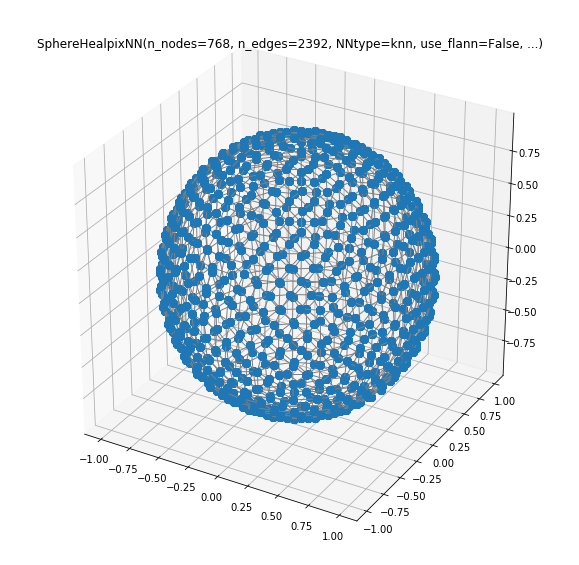

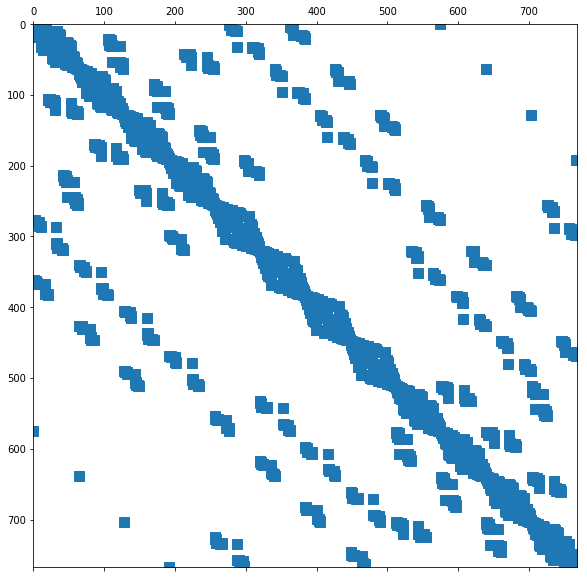

In [368]:
graphHpNN.plot()
plt.figure()
plt.spy(graphHpNN.W)

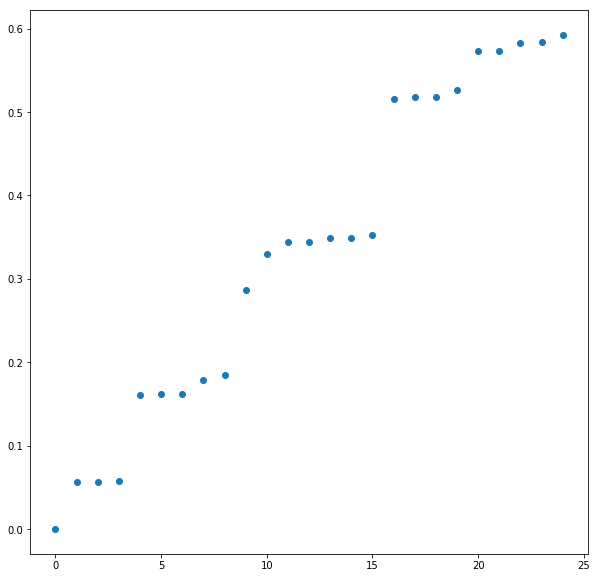

In [370]:
plt.plot(graphHp.e[:25], 'o')

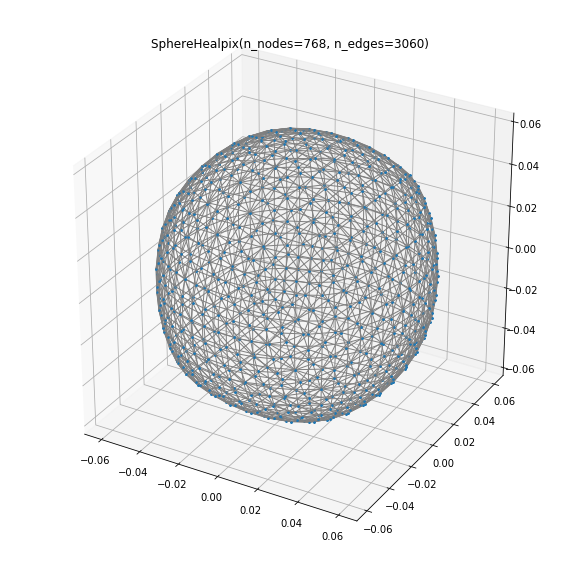

<Figure size 720x720 with 0 Axes>

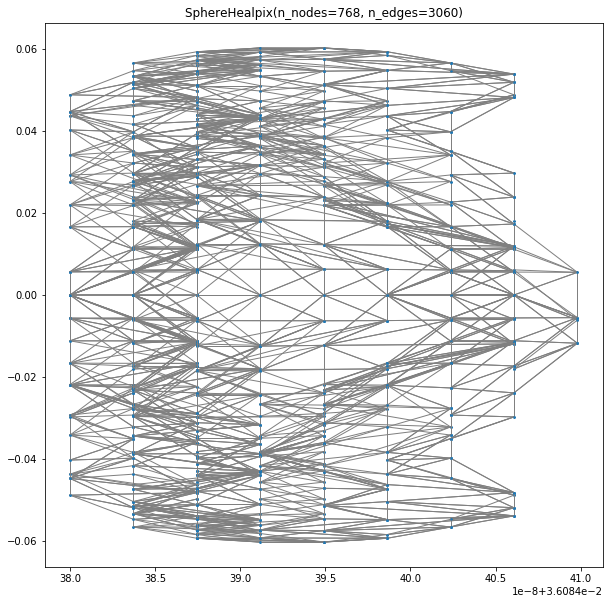

In [371]:
graphHp.compute_laplacian("combinatorial")
#graphCyl.compute_fourier_basis(recompute=True)
graphHp.set_coordinates(graphHp.U[:,1:4])
graphHp.plot(vertex_size=10)
fig=plt.figure()


graphHp.set_coordinates(graphHp.U[:,0:2])
graphHp.plot(vertex_size=10)

In [254]:
class SphereEquiangular(Graph):
    def __init__(self, bw=64, sptype='DH', pole='all', neighbors=8, weights=None, dist='geodesic', 
                 affine=0., **kwargs):
        """Sphere with an equiangular sampling
         Parameters
        ----------
        bw : int
            bandwidth, size of grid  (default = 64)
        sptype: str
            sampling type, possible arguments are 'DH', 'SOFT', ... (default = 'DH')
        pole: str
            how to manage the pole of the sphere, possible arguments are 'all', 'one', 'zero' (default = 'all')
        ---------
        TODO: unique on neighbor
        TODO: CC and GL are not equiangular and must be implement in other ways
        """
        self.bw = bw
        self.sptype = sptype
        self.pole = pole
        if pole not in ['all', 'one', 'zero']:
            raise ValueError('Unknown pole value:' + pole) 
        if sptype not in ['DH', 'SOFT']:
            raise ValueError('Unknown sampling type:' + sptype) 
        if sptype is not 'DH' and pole is not 'zero':
            print('pole can be only zero with sampling type ' + sptype)
            pole = 'zero'
        
        ## sampling and coordinates calculation
        if sptype is 'DH':
            beta = np.arange(2 * bw) * np.pi / (2. * bw)  # Driscoll-Heally
            alpha = np.arange(2 * bw) * np.pi / bw
            if pole is 'zero':
                beta = np.arange(2 * bw + 1) * np.pi / (2. * bw + 1)
        elif sptype is 'SOFT':  # SO(3) Fourier Transform optimal
            beta = np.pi * (2 * np.arange(2 * bw) + 1) / (4. * bw)
            alpha = np.arange(2 * bw) * np.pi / bw
        elif sptype == 'CC':  # Clenshaw-Curtis
            beta = np.linspace(0, np.pi, 2 * bw + 1)
            alpha = np.linspace(0, 2 * np.pi, 2 * bw + 2, endpoint=False)
        elif sptype == 'GL':  # Gauss-legendre
            from numpy.polynomial.legendre import leggauss
            x, _ = leggauss(bw + 1)  # TODO: leggauss docs state that this may not be only stable for orders > 100
            beta = np.arccos(x)
            alpha = np.arange(2 * bw + 2) * np.pi / (bw + 1)
        if pole is not 'all' and sptype is 'DH':
            beta = beta[1:]
        theta, phi = np.meshgrid(*(beta, alpha),indexing='ij')
        ct = np.cos(theta).flatten()
        st = np.sin(theta).flatten()
        cp = np.cos(phi).flatten()
        sp = np.sin(phi).flatten()
        x = st * cp
        y = st * sp
        z = ct
        coords = np.vstack([x, y, z]).T
        if pole is 'one':
            coords = np.vstack([[0., 0., 1.],coords])
        coords = np.asarray(coords, dtype=np.float32)
        
        ## neighbors and weight matrix calculation
        def south(x, bw):
            if x >= (2*bw)*(2*bw-1):
                return north((x+bw)%(2*bw)+(2*bw)*(2*bw),bw)
            elif self.pole is 'zero' and x >= (2*bw)*(2*bw-1):
                return north((x+bw)%(2*bw)+(2*bw)*(2*bw-1),bw)
            else:
                return x + 2*bw

        def north(x, bw):
            if x < 2*bw:
                return (x+bw)%(2*bw)
            else:
                return x - 2*bw

        def west(x, bw):
            if x%(2*bw)==0:
                x += 2*bw
            return x -1

        def east(x, bw):
            if x%(2*bw)==2*bw-1:
                x -= 2*bw
            return x + 1

        npix = len(coords)
        col_index=[]
        for ind in range(len(coords)):
            # first line is the same point, so is connected to all points of second line
            if pole is 'all' and sptype and ind < 2* bw:
                if ind == 0:
                    neighbor = np.arange(2*bw)+2*bw # np.arange(1,4*bw)
                else:
                    neighbor = np.arange(2*bw)+2*bw # [0]
            elif pole is 'all' and ind < 4*bw:
                if neighbors==8:
                    neighbor = [south(west(ind,bw),bw), west(ind,bw), east(ind,bw), south(east(ind,bw),bw), south(ind,bw)]
                elif neighbors==4:
                    neighbor = [west(ind,bw), east(ind,bw), south(ind,bw)]
                else:
                    neighbor = []
                neighbor += list(range(2*bw)) # [0]
            elif pole is 'one' and ind == 0:
                neighbor = np.arange(1, 2*bw+1)
            elif pole is 'one' and ind < 2*bw+1:
                ind += 2*bw - 1
                if neighbors==8:
                    neighbor = [south(west(ind,bw),bw), west(ind,bw), east(ind,bw), south(east(ind,bw),bw), south(ind,bw)]
                elif neighbors==4:
                    neighbor = [west(ind,bw), east(ind,bw), south(ind,bw)]
                else:
                    neighbor = []
                neighbor += [0]
            else:
                if pole is 'one':
                    ind += 2*bw - 1
                if neighbors==8:
                    neighbor = [south(west(ind,bw),bw), west(ind,bw), north(west(ind,bw), bw), north(ind,bw), 
                                north(east(ind,bw),bw), east(ind,bw), south(east(ind,bw),bw), south(ind,bw)]
                elif neighbors==4:
                    neighbor = [west(ind,bw), north(ind,bw), east(ind,bw), south(ind,bw)]
                else:
                    neighbor = []
            neighbor = np.asarray(neighbor)
            if pole is 'one' and ind != 0:
                neighbor -= 2*bw - 1
                neighbor[neighbor<0] = 0
            #neighbors.append(neighbor)
            col_index += list(neighbor)
        # neighbors = np.asarray(neighbors)
        col_index = np.asarray(col_index)

        #col_index = neighbors.reshape((-1))
        if pole is 'all':
            row_index = np.hstack([np.repeat(np.arange(0,2*bw), 2*bw), np.repeat(np.arange(2*bw,4*bw), neighbors//2+1+2*bw),#2*bw+5), 
                                  np.repeat(np.arange(4*bw, npix), neighbors)])
        elif pole is 'one':
            row_index = np.hstack([np.repeat(0, 2*bw), np.repeat(np.arange(1, 2*bw+1), neighbors//2+2),
                                  np.repeat(np.arange(2*bw+1, npix), neighbors)])
        elif pole is 'zero':
            row_index = np.repeat(np.arange(npix), neighbors)

        distances = np.sum((coords[row_index] - coords[col_index])**2, axis=1)
        # slower: np.linalg.norm(coords[row_index] - coords[col_index], axis=1)**2
        if dist=='geodesic':
            distances = np.zeros(len(row_index))
            for i, (pos1, pos2) in enumerate(zip(coords[row_index], coords[col_index])):
                d1, d2 = hp.rotator.vec2dir(pos1.T, lonlat=False).T, hp.rotator.vec2dir(pos2.T, lonlat=False).T
                distances[i] = hp.rotator.angdist(d1, d2, lonlat=False)

        # Compute similarities / edge weights.
        kernel_width = np.mean(distances)
        kernel_width2 = np.median(distances)
#         distances = kernel_width*(distances/kernel_width) ** 0.1
        slope = (kernel_width*(0.95-affine))/(kernel_width*0.95)
        distances[distances<(kernel_width*0.95)] = affine*kernel_width + distances[distances<(kernel_width*0.95)] * slope
#         distances[distances<(kernel_width*0.8)] = kernel_width*0.8
#         distances[distances>(kernel_width)] = kernel_width
#         distances[distances<(kernel_width)] = kernel_width*(distances[distances<(kernel_width)]/kernel_width) ** 0.05#kernel_width*0.8
#         distances[distances>(kernel_width)] = kernel_width*(distances[distances>(kernel_width)]/kernel_width) ** 0.5#distances[distances>(kernel_width*1.3)]/2
        if isinstance(weights, int):
            kernel_width = weights
        weights = np.exp(-distances / (2 * kernel_width))
        
        plt.hist(distances, 100)
        
        if weights == 'one':
            weights = distances/distances


        # Similarity proposed by Renata & Pascal, ICCV 2017.
        # weights = 1 / distances

        # Build the sparse matrix.
        W = sparse.csr_matrix(
            (weights, (row_index, col_index)), shape=(npix, npix), dtype=np.float32)
        
        plotting = {"limits": np.array([-1, 1, -1, 1, -1, 1])}
        super(SphereEquiangular, self).__init__(W=W, coords=coords,
                                     plotting=plotting, **kwargs)

/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/ipykernel_launcher.py:166: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


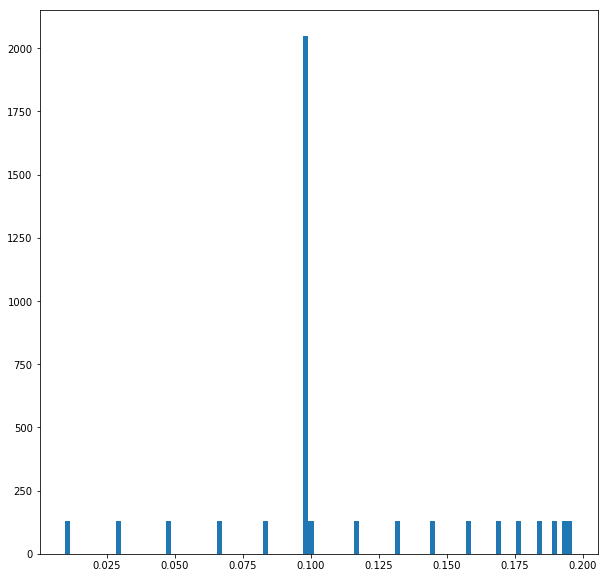

In [581]:
graphAll = SphereEquiangular(16, 'SOFT', 'zero', 4)

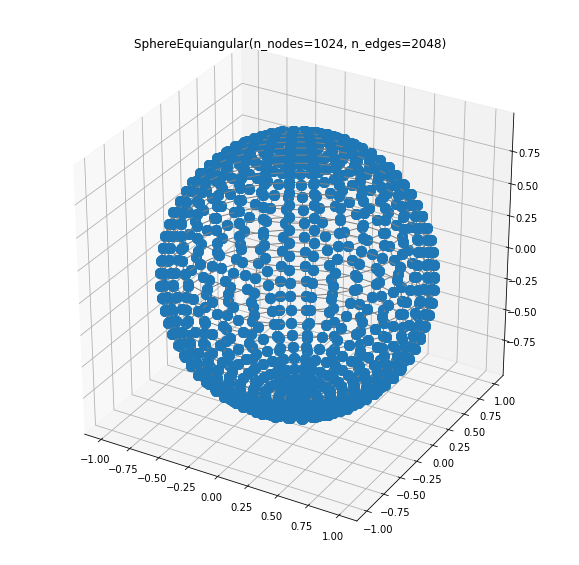

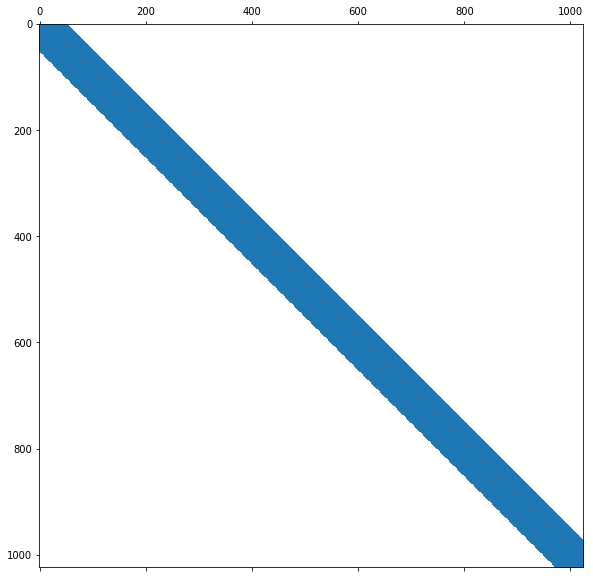

In [488]:
graphAll.plot()
plt.figure()
plt.spy(graphAll.W)

In [45]:
graphAll = SphereEquiangular(2, 'DH', 'all')

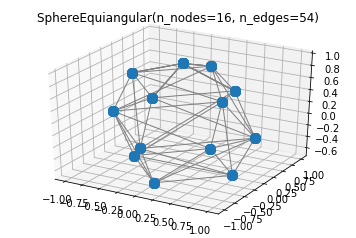

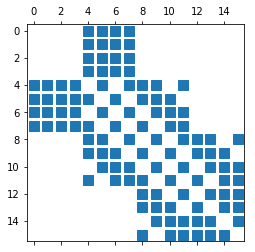

In [46]:
graphAll.plot()
plt.figure()
plt.spy(graphAll.W)

In [47]:
graphOne = SphereEquiangular(2, 'DH', 'one')

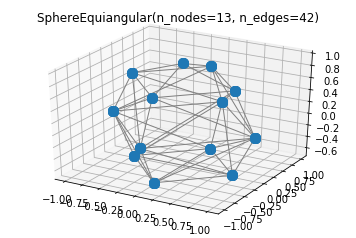

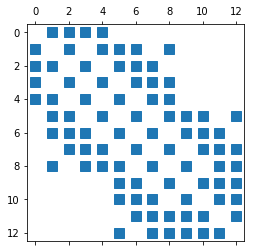

In [48]:
graphOne.plot()
plt.figure()
plt.spy(graphOne.W)

In [49]:
graphZero = SphereEquiangular(2, 'DH', 'zero')

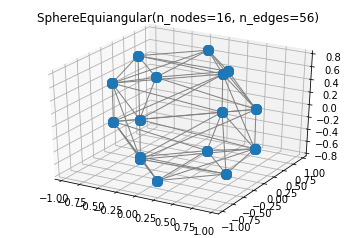

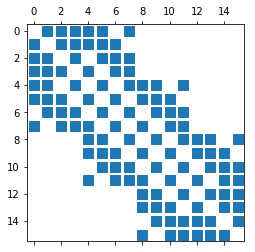

In [50]:
graphZero.plot()
plt.figure()
plt.spy(graphZero.W)

/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/ipykernel_launcher.py:166: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


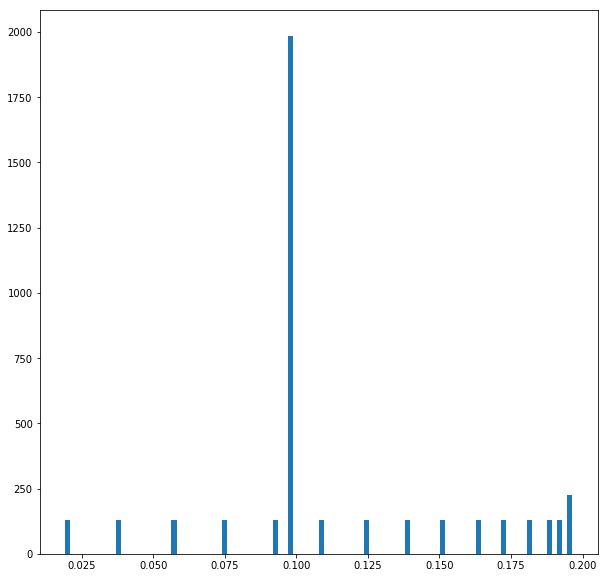

In [259]:
graphEqui = SphereEquiangular(16, 'DH', 'one', 4, dist='geodesic', affine=0.)

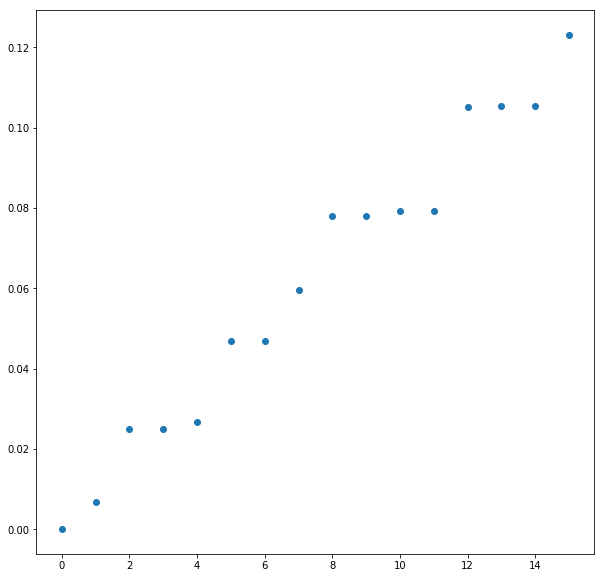

In [261]:
plt.plot(graphEqui.e[:16], 'o')

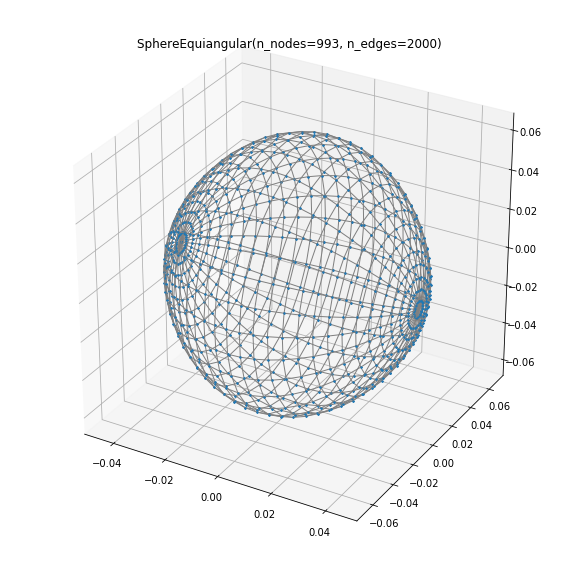

<Figure size 720x720 with 0 Axes>

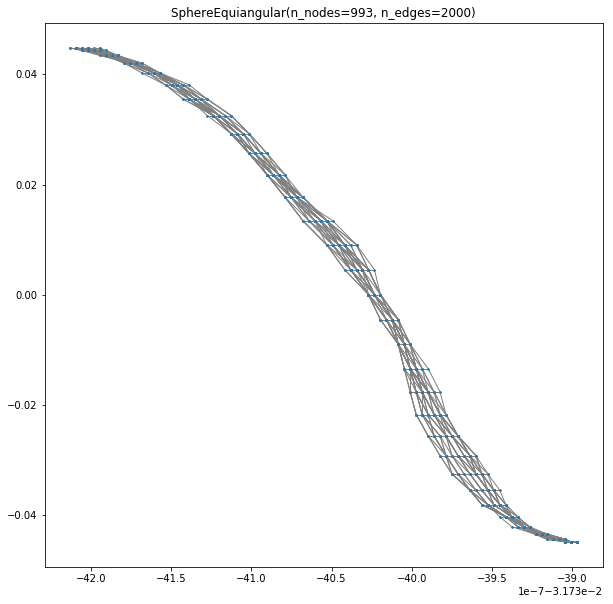

In [262]:
graphEqui.compute_laplacian("combinatorial")
#graphAll.compute_fourier_basis(recompute=True)
graphEqui.set_coordinates(graphEqui.U[:,1:4])
graphEqui.plot(vertex_size=10)
fig=plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(graphAll.U[:,0], graphAll.U[:,1], graphAll.U[:,2])

graphEqui.set_coordinates(graphEqui.U[:,0:2])
graphEqui.plot(vertex_size=10)

In [372]:
class SphereEquiangularNN(NNGraph):
    def __init__(self, bw=64, sptype='DH', pole='zero', neighbors=8, weights=None,  **kwargs):
        """Sphere with an equiangular sampling
         Parameters
        ----------
        bw : int
            bandwidth, size of grid  (default = 64)
        sptype: str
            sampling type, possible arguments are 'DH', 'SOFT', ... (default = 'DH')
        pole: str
            how to manage the pole of the cylinder, possible arguments are 'disconnected', 'connected' (default = 'disconnected')
        ---------
        TODO: unique on neighbor
        TODO: CC and GL are not equiangular and must be implement in other ways
        """
        self.bw = bw
        self.sptype = sptype
        self.pole = pole
        if pole not in ['all', 'zero', 'one']:
            raise ValueError('Unknown pole value:' + pole) 
        if sptype not in ['DH', 'SOFT', 'CC', 'GL']:
            raise ValueError('Unknown sampling type:' + sptype) 
        if sptype is not 'DH' and pole is not 'zero':
            print('pole can be only zero with sampling type ' + sptype)
            pole = 'zero'
        
        ## sampling and coordinates calculation
        if sptype is 'DH':
            beta = np.arange(2 * bw) * np.pi / (2. * bw)  # Driscoll-Heally
            alpha = np.arange(2 * bw) * np.pi / bw
            if pole is 'zero':
                beta = np.arange(2 * bw + 1) * np.pi / (2. * bw + 1)
        elif sptype is 'SOFT':  # SO(3) Fourier Transform optimal
            beta = np.pi * (2 * np.arange(2 * bw) + 1) / (4. * bw)
            alpha = np.arange(2 * bw) * np.pi / bw
        elif sptype == 'CC':  # Clenshaw-Curtis
            beta = np.linspace(0, np.pi, 2 * bw + 1)
            alpha = np.linspace(0, 2 * np.pi, 2 * bw + 2, endpoint=False)
        elif sptype == 'GL':  # Gauss-legendre
            from numpy.polynomial.legendre import leggauss
            x, _ = leggauss(bw + 1)  # TODO: leggauss docs state that this may not be only stable for orders > 100
            beta = np.arccos(x)
            alpha = np.arange(2 * bw + 2) * np.pi / (bw + 1)
        if pole is not 'all' and sptype is 'DH':
            beta = beta[1:]
        theta, phi = np.meshgrid(*(beta, alpha),indexing='ij')
        ct = np.cos(theta).flatten()
        st = np.sin(theta).flatten()
        cp = np.cos(phi).flatten()
        sp = np.sin(phi).flatten()
        x = st * cp
        y = st * sp
        z = ct
        coords = np.vstack([x, y, z]).T
        if pole is 'one':
            coords = np.vstack([[0., 0., 1.],coords])
        coords = np.asarray(coords, dtype=np.float32)
        self.npix = len(coords)
        if neighbors == 'all':
            neighbors = self.npix-1
        
        plotting = {"limits": np.array([-1, 1, -1, 1, -1, 1])}
        super(SphereEquiangularNN, self).__init__(coords, k=neighbors, center=False, rescale=False,
                                     plotting=plotting, **kwargs)

In [373]:
equiNN = SphereEquiangularNN(4, 'SOFT', pole='zero', neighbors='all')

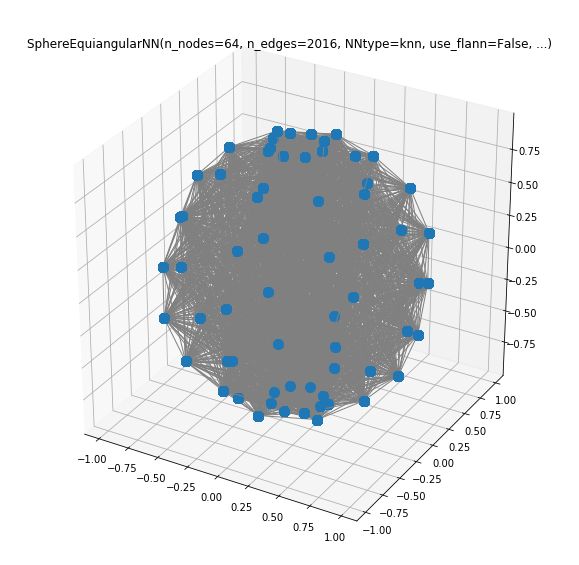

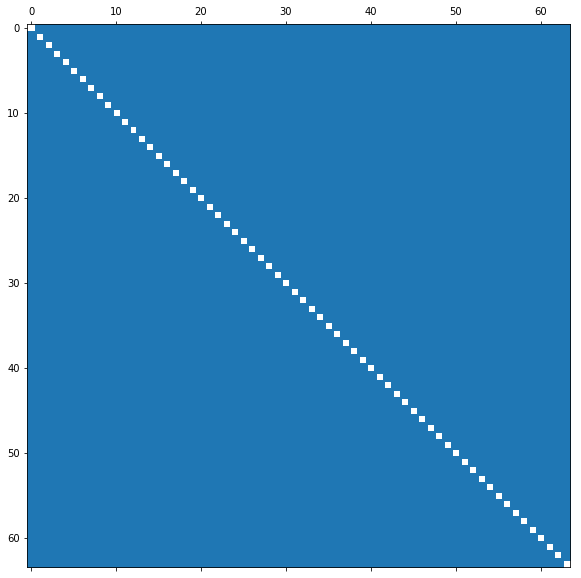

In [374]:
equiNN.plot()
plt.figure()
plt.spy(equiNN.W)

2019-04-30 11:01:52,724:[WARNING](pygsp.graphs.graph._check_fourier_properties): The eigenvalues vector G.e is not available, we need to compute the Fourier basis. Explicitly call G.compute_fourier_basis() once beforehand to suppress the warning.


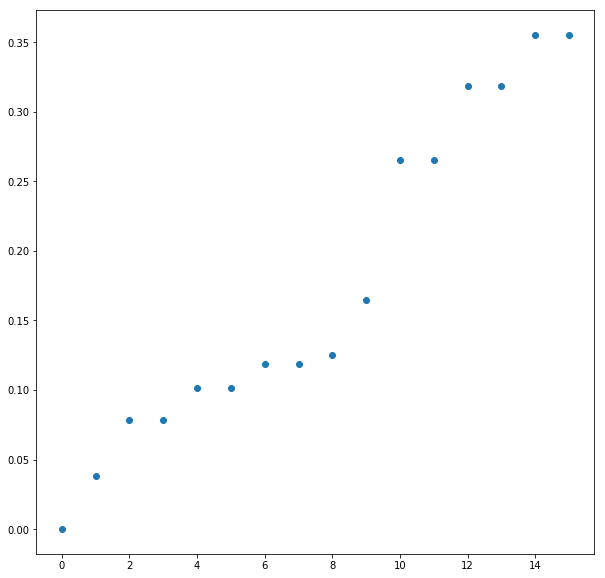

In [375]:
plt.plot(equiNN.e[:16], 'o')

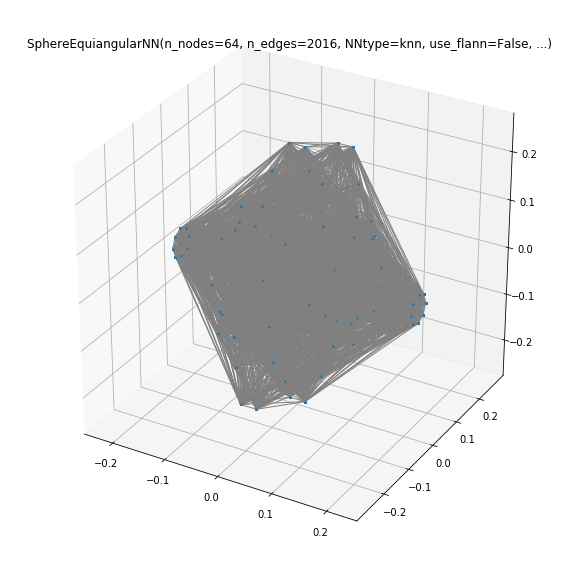

<Figure size 720x720 with 0 Axes>

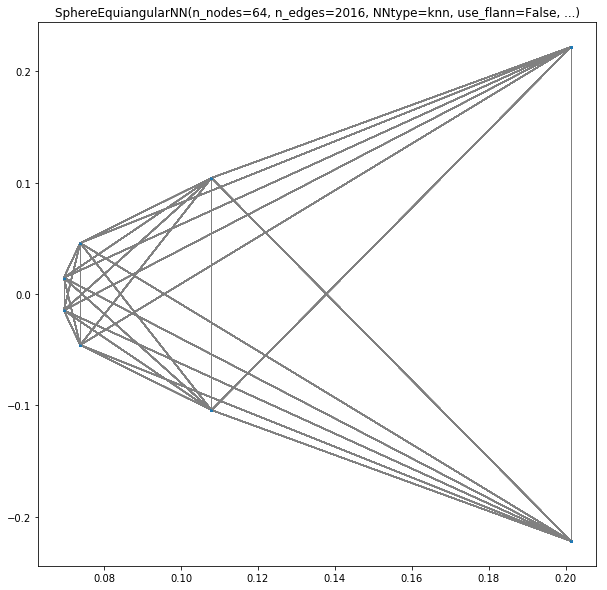

In [376]:
equiNN.compute_laplacian("normalized")
equiNN.compute_fourier_basis(recompute=True)
equiNN.set_coordinates(equiNN.U[:,1:4])
equiNN.plot(vertex_size=10)
fig=plt.figure()


equiNN.set_coordinates(equiNN.U[:,0:2])
equiNN.plot(vertex_size=10)

In [379]:
class CylinderEquiangular(Graph):
    def __init__(self, bw=64, sptype='DH', pole='disconnected', neighbors=8, w_mat=None, dist='geodesic', 
                 affine=0., **kwargs):
        """Sphere with an equiangular sampling
         Parameters
        ----------
        bw : int
            bandwidth, size of grid  (default = 64)
        sptype: str
            sampling type, possible arguments are 'DH', 'SOFT', ... (default = 'DH')
        pole: str
            how to manage the pole of the cylinder, possible arguments are 'disconnected', 'connected' (default = 'disconnected')
        ---------
        TODO: unique on neighbor
        TODO: CC and GL are not equiangular and must be implement in other ways
        """
        self.bw = bw
        self.sptype = sptype
        self.pole = pole
        if pole not in ['disconnected', 'connected']:
            raise ValueError('Unknown pole value:' + pole) 
        if sptype not in ['DH', 'SOFT', 'CC', 'GL']:
            raise ValueError('Unknown sampling type:' + sptype) 
        if neighbors not in [4, 8, 'all']:
            raise ValueError('impossible numbers of neighbors:' + neighbors) 
        
        ## sampling and coordinates calculation
        if sptype is 'DH':
            beta = np.arange(2 * bw) * np.pi / (2. * bw)  # Driscoll-Heally
            alpha = np.arange(2 * bw) * np.pi / bw
        elif sptype is 'SOFT':  # SO(3) Fourier Transform optimal
            beta = np.pi * (2 * np.arange(2 * bw) + 1) / (4. * bw)
            alpha = np.arange(2 * bw) * np.pi / bw
        elif sptype == 'CC':  # Clenshaw-Curtis
            beta = np.linspace(0, np.pi, 2 * bw + 1)
            alpha = np.linspace(0, 2 * np.pi, 2 * bw + 2, endpoint=False)
        elif sptype == 'GL':  # Gauss-legendre
            from numpy.polynomial.legendre import leggauss
            x, _ = leggauss(bw + 1)  # TODO: leggauss docs state that this may not be only stable for orders > 100
            beta = np.arccos(x)
            alpha = np.arange(2 * bw + 2) * np.pi / (bw + 1)
        theta, phi = np.meshgrid(*(beta, alpha),indexing='ij')
        self.lat, self.lon = theta.shape
        # do we want cylinder coordinates?
        ct = np.cos(theta).flatten()  # theta.flatten()
#         ct = theta.flatten()
        st = np.sin(theta).flatten()  # 1
#         st = 1
        cp = np.cos(phi).flatten()
        sp = np.sin(phi).flatten()
        x = st * cp
        y = st * sp
        z = ct
        coords = np.vstack([x, y, z]).T
        coords = np.asarray(coords, dtype=np.float32)
        self.npix = len(coords)
        
        ## neighbors and weight matrix calculation
        def south(x):
            if x >= self.npix - self.lat:
                if pole == 'connected':
                    return (x + self.lat//2)%self.lat + self.npix - self.lat
                else:
                    return -1
            return x + self.lon

        def north(x):
            if x < self.lat:
                if pole == 'connected':
                    return (x + self.lat//2)%self.lat
                else:
                    return -1
            return x - self.lon

        def west(x):
            if x%(self.lon)==0:
                x += self.lon
            return x -1

        def east(x):
            if x%(self.lon)==self.lon-1:
                x -= self.lon
            return x + 1

        col_index=[]
        for ind in range(self.npix):
            # first line is the same point, so is connected to all points of second line
            if neighbors==8:
                neighbor = [south(west(ind)), west(ind), north(west(ind)), north(ind), 
                            north(east(ind)), east(ind), south(east(ind)), south(ind)]
            elif neighbors==4:
                neighbor = [west(ind), north(ind), east(ind), south(ind)]
            elif neighbors=='all':
                neighbor = set(range(self.npix))-{ind}
            else:
                neighbor = []
            #neighbor = np.asarray(neighbor)
            col_index += list(neighbor)
        col_index = np.asarray(col_index)
        if neighbors == 'all':
            neighbors = self.npix - 1
        row_index = np.repeat(np.arange(self.npix), neighbors)
        
        keep = (col_index < self.npix)
        keep &= (col_index >= 0)
        col_index = col_index[keep]
        row_index = row_index[keep]
        
        if w_mat is not 'one':
            distances = np.sum((coords[row_index] - coords[col_index])**2, axis=1)
            # slower: np.linalg.norm(coords[row_index] - coords[col_index], axis=1)**2
            if dist=='geodesic':
                distances = np.zeros(len(row_index))
                for i, (pos1, pos2) in enumerate(zip(coords[row_index], coords[col_index])):
                    d1, d2 = hp.rotator.vec2dir(pos1.T, lonlat=False).T, hp.rotator.vec2dir(pos2.T, lonlat=False).T
                    distances[i] = hp.rotator.angdist(d1, d2, lonlat=False)

            # Compute similarities / edge weights.
            kernel_width = np.mean(distances)
            kernel_width2 = np.median(distances)

            slope = (kernel_width2*(0.95-affine))/(kernel_width2*0.95)
            #distances[distances<(kernel_width2*0.95)] = affine*kernel_width2 + distances[distances<(kernel_width2*0.95)] * slope
            #distances[distances>(kernel_width2*0.95)] = affine*kernel_width2 + distances[distances>(kernel_width2*0.95)] * slope
            if isinstance(w_mat, int):
                kernel_width = weights
            weights = np.exp(-distances / (2 * kernel_width2))

            plt.hist(distances, 100)
        if w_mat == 'one':
            weights = np.ones((len(row_index),))
            near_pole = col_index<2
            near_pole &= col_index>self.lat-2
            weights[near_pole] *= 0.1

        # Similarity proposed by Renata & Pascal, ICCV 2017.
        # weights = 1 / distances

        # Build the sparse matrix.
        W = sparse.csr_matrix(
            (weights, (row_index, col_index)), shape=(self.npix, self.npix), dtype=np.float32)
        
        plotting = {"limits": np.array([-1, 1, -1, 1, -1, 1])}
        super(CylinderEquiangular, self).__init__(W=W, coords=coords,
                                     plotting=plotting, **kwargs)

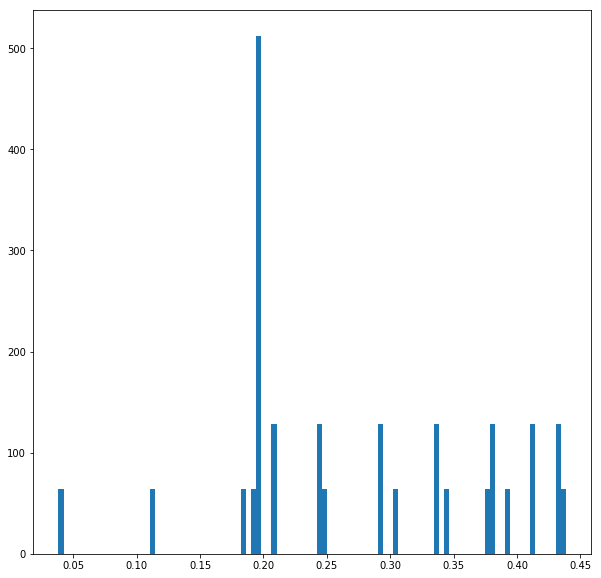

In [422]:
graphCyl = CylinderEquiangular(8, 'SOFT', 'connected', neighbors=8, w_mat=None, dist='geodesic', affine=0.0)

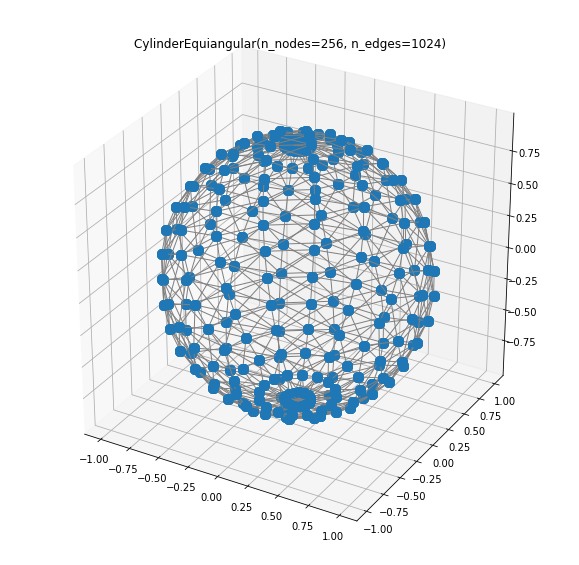

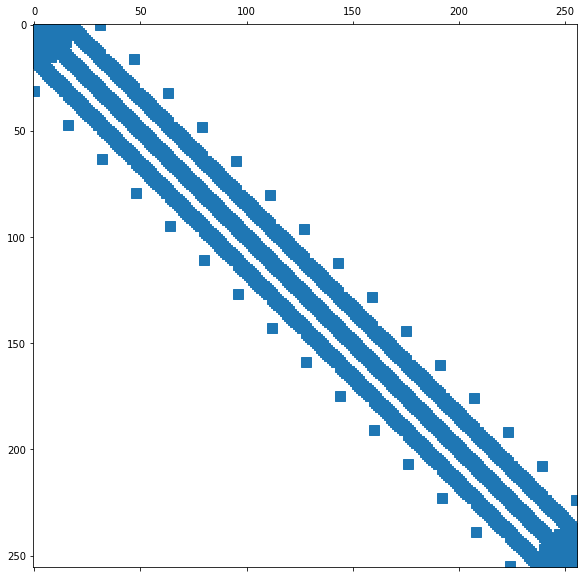

In [423]:
graphCyl.plot()
plt.figure()
plt.spy(graphCyl.W)

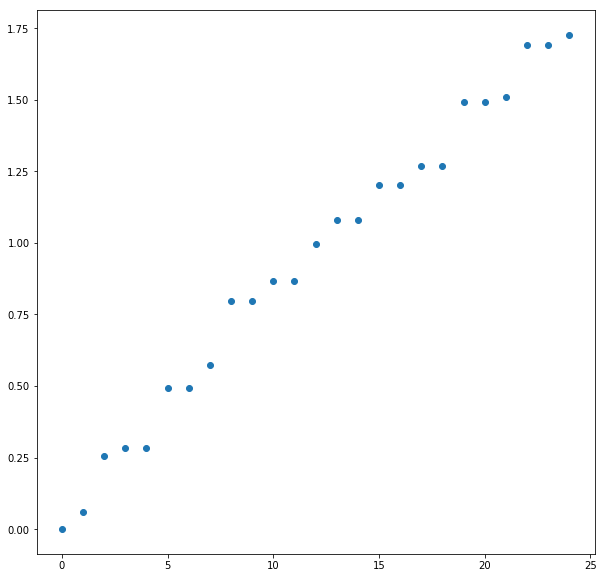

In [425]:
plt.plot(graphCyl.e[:25], 'o')

AttributeError: Coordinates should be in 2D or 3D space.

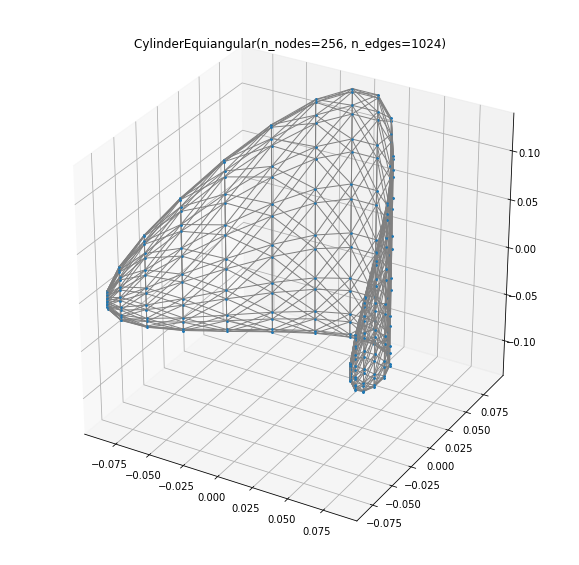

<Figure size 720x720 with 0 Axes>

In [410]:
graphCyl.compute_laplacian("combinatorial")
#graphCyl.compute_fourier_basis(recompute=True)
graphCyl.set_coordinates(graphCyl.U[:,1:4])
graphCyl.plot(vertex_size=10)
fig=plt.figure()

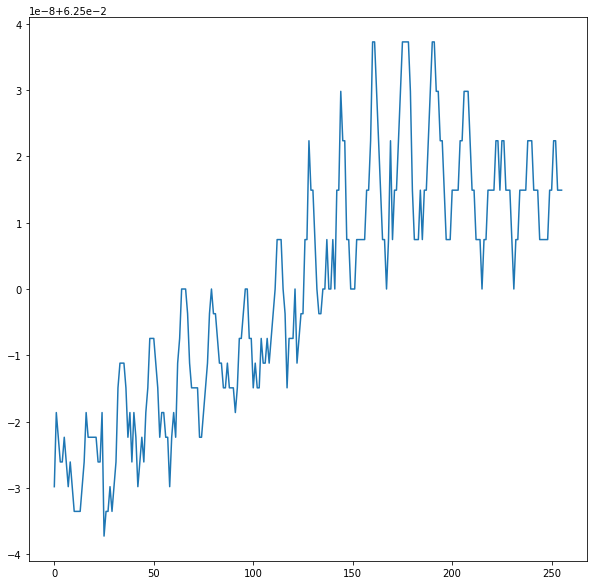

In [415]:
plt.plot(graphCyl.U[:,0])

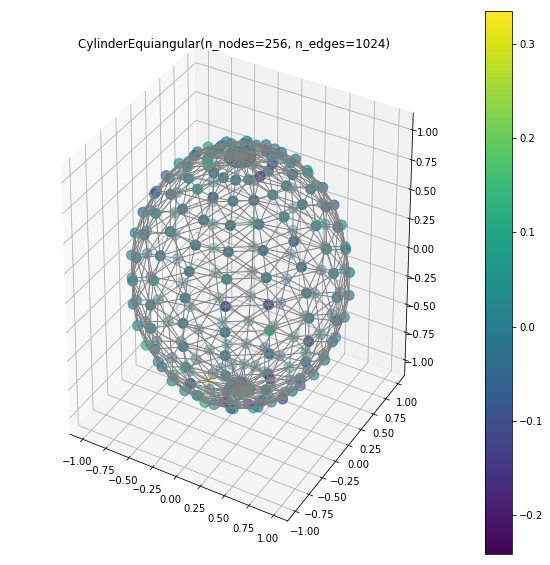

In [409]:
graphCyl.plot_signal(graphCyl.U[0])

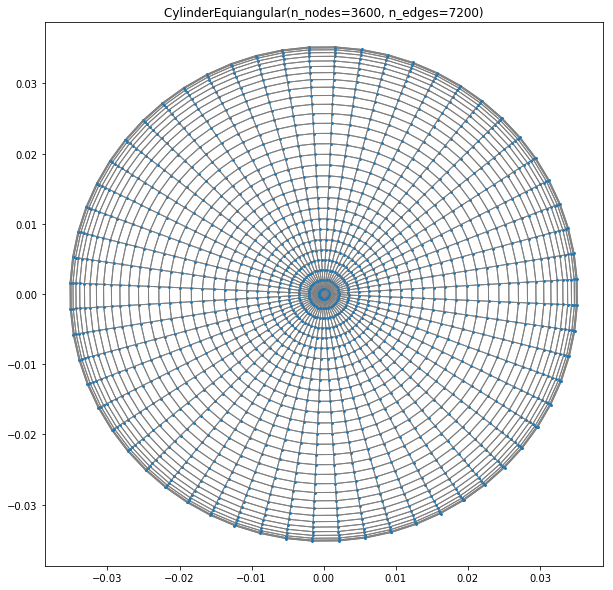

In [350]:
graphCyl.set_coordinates(graphCyl.U[:,2:4])
graphCyl.plot(vertex_size=10)

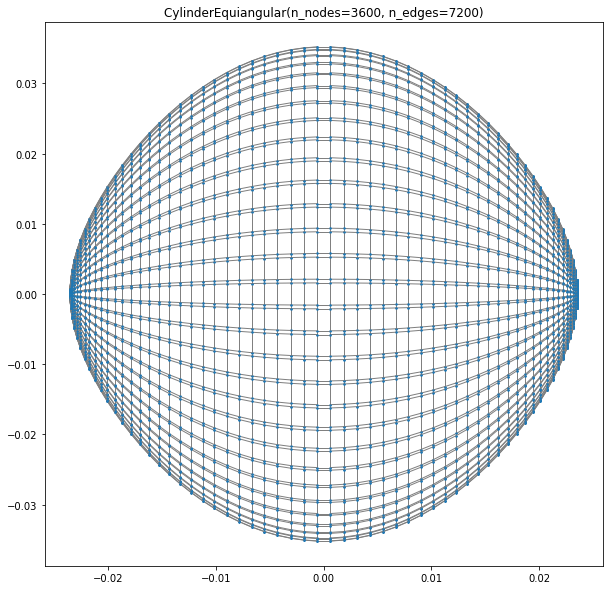

In [351]:
graphCyl.set_coordinates(graphCyl.U[:,1:3])
graphCyl.plot(vertex_size=10)